# Music_genre Classification

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import pathlib
import librosa
import librosa.display
import IPython.display
import csv
from sklearn.preprocessing import LabelEncoder, StandardScaler

import keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, GlobalAveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD

import tensorflow as tf

## Collection of DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
for folder in os.listdir(f'/content/drive/My Drive/Music/genres/'):
    print(folder)
    pathlib.Path(f'Spec_img/{folder}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'/content/drive/My Drive/Music/genres/{folder}'):
        print(filename)
        songname = f'/content/drive/My Drive/Music/genres/{folder}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        print(y.shape)
        print(sr)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'Spec_img/{folder}/{filename[:-3].replace(".", "_")}.png')
        plt.clf()    

## Generating Mel-Spectrogram 

In [ ]:
header = "music_genres chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate"
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
'''Creating CSV file of each song WIth RMSE,Chroma Stft,Spectral centroid,
Spectral Bandwidth,Zero Cross Rate,MFCC'''
spectral_data = open('Spec_data.csv', 'w', newline='')
with spectral_data:
    writer = csv.writer(spectral_data)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'/content/drive/My Drive/Music/genres/{g}'):
        songname = f'/content/drive/My Drive/Music/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        rmse = librosa.feature.rmse(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        spectral_data = open('Spec_data.csv', 'a', newline='')
        # with file:
        writer = csv.writer(spectral_data)
        writer.writerow(to_append.split())


## Spliting DATA into Train and Test

In [ ]:
!pip install split-folders tqdm

import splitfolders
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio('/content/drive/My Drive/music-genre-classification/Spec_img', output="/content/drive/My Drive/music-genre-classification/Gtv", seed=1337, ratio=(.80, .20)) # default values



# image augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale = 1./255, # rescale all pixel values from 0-255, so aftre this step all our pixel values are in range (0,1)
        shear_range = 0.2, #to apply some random tranfromations
        zoom_range = 0.2, #to apply zoom
        horizontal_flip = True) # image will be flipper horiz
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# # ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.
training_set = train_datagen.flow_from_directory(
        '/content/drive/My Drive/music-genre-classification/Gtv/train',
        target_size = (300,300),
        batch_size = 32,
        class_mode='categorical',
        shuffle = False)
test_set = test_datagen.flow_from_directory(
        '/content/drive/My Drive/music-genre-classification/Gtv/val',
        target_size = (300,300),
         batch_size = 32,
        class_mode='categorical',
        shuffle = False )



Found 800 images belonging to 11 classes.
Found 200 images belonging to 11 classes.


## Model used

In [ ]:
from tensorflow.keras.applications import Xception

In [ ]:
base_model=Xception(include_top=False,input_shape=(300,300,3))

# Create new model on top
inputs = tf.keras.Input(shape=(300,300,3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # 1st improove Regularize with dropout
x = tf.keras.layers.Dense(512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x) # 2st improove Regularize with dropout
x = tf.keras.layers.Dense(64,activation='relu')(x)
outputs = tf.keras.layers.Dense(11,activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

## Model Traing and Testing (Using Optimizer = "SGD","ADAM")

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['acc'])
warmup = model.fit(training_set, validation_data=test_set,epochs=100)

Epoch 1/100
25/25 [==============================] - 65s 3s/step - loss: 2.4549 - acc: 0.0475 - val_loss: 2.3553 - val_acc: 0.1250
Epoch 2/100
25/25 [==============================] - 64s 3s/step - loss: 2.3838 - acc: 0.1175 - val_loss: 2.3146 - val_acc: 0.1950
Epoch 3/100
25/25 [==============================] - 64s 3s/step - loss: 2.3453 - acc: 0.1013 - val_loss: 2.3145 - val_acc: 0.1300
Epoch 4/100
25/25 [==============================] - 65s 3s/step - loss: 2.3250 - acc: 0.1450 - val_loss: 2.2190 - val_acc: 0.2350
Epoch 5/100
25/25 [==============================] - 64s 3s/step - loss: 2.2821 - acc: 0.1037 - val_loss: 2.0691 - val_acc: 0.2500
Epoch 6/100
25/25 [==============================] - 64s 3s/step - loss: 2.2227 - acc: 0.1363 - val_loss: 2.0672 - val_acc: 0.2200
Epoch 7/100
25/25 [==============================] - 64s 3s/step - loss: 2.1641 - acc: 0.1700 - val_loss: 2.0762 - val_acc: 0.2500
Epoch 8/100
25/25 [==============================] - 64s 3s/step - loss: 2.2579 - a

In [ ]:
 model.evaluate(test_set)

7/7 [==============================] - 3s 450ms/step - loss: 1.5692 - acc: 0.5100


[1.5692222118377686, 0.5099999904632568]

In [ ]:
base_model.trainable = True
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-5)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
final =  model.fit(training_set, validation_data=test_set,epochs=100)

Epoch 1/100
25/25 [==============================] - 66s 3s/step - loss: 0.6116 - acc: 0.7713 - val_loss: 1.4852 - val_acc: 0.5700
Epoch 2/100
25/25 [==============================] - 66s 3s/step - loss: 0.5031 - acc: 0.8163 - val_loss: 1.5032 - val_acc: 0.5800
Epoch 3/100
25/25 [==============================] - 65s 3s/step - loss: 0.4775 - acc: 0.8238 - val_loss: 1.5682 - val_acc: 0.5950
Epoch 4/100
25/25 [==============================] - 65s 3s/step - loss: 0.4362 - acc: 0.8438 - val_loss: 1.6091 - val_acc: 0.5850
Epoch 5/100
25/25 [==============================] - 65s 3s/step - loss: 0.3745 - acc: 0.8625 - val_loss: 1.6710 - val_acc: 0.5800
Epoch 6/100
25/25 [==============================] - 65s 3s/step - loss: 0.3801 - acc: 0.8512 - val_loss: 1.7770 - val_acc: 0.5750
Epoch 7/100
25/25 [==============================] - 65s 3s/step - loss: 0.3565 - acc: 0.8512 - val_loss: 1.7419 - val_acc: 0.6150
Epoch 8/100
25/25 [==============================] - 65s 3s/step - loss: 0.3510 - a

In [ ]:
test_set.reset()
pred = model.predict_generator(test_set, steps = 20, verbose = 0)

In [ ]:
 model.evaluate(test_set)

7/7 [==============================] - 3s 455ms/step - loss: 3.6114 - acc: 0.5750


[3.6113967895507812, 0.574999988079071]

### Ploting Accuracy

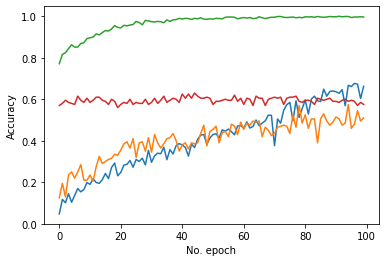

In [ ]:
plt.plot(range(0,100), warmup.history['acc'], label='Warmup Accuracy (training data)')
plt.plot(range(0,100), warmup.history['val_acc'], label='Warmup Accuracy (validation data)')

plt.plot(range(0,100), final.history['acc'], label='Final Accuracy (training data)')
plt.plot(range(0,100), final.history['val_acc'], label='Final Accuracy (validation data)')

plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
#plt.legend(loc="upper left")
plt.show()

## Saving Output Data into CSV file. 

There are 999 rows and 28 columns


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3141bcd1d0>,
      dtype=object)

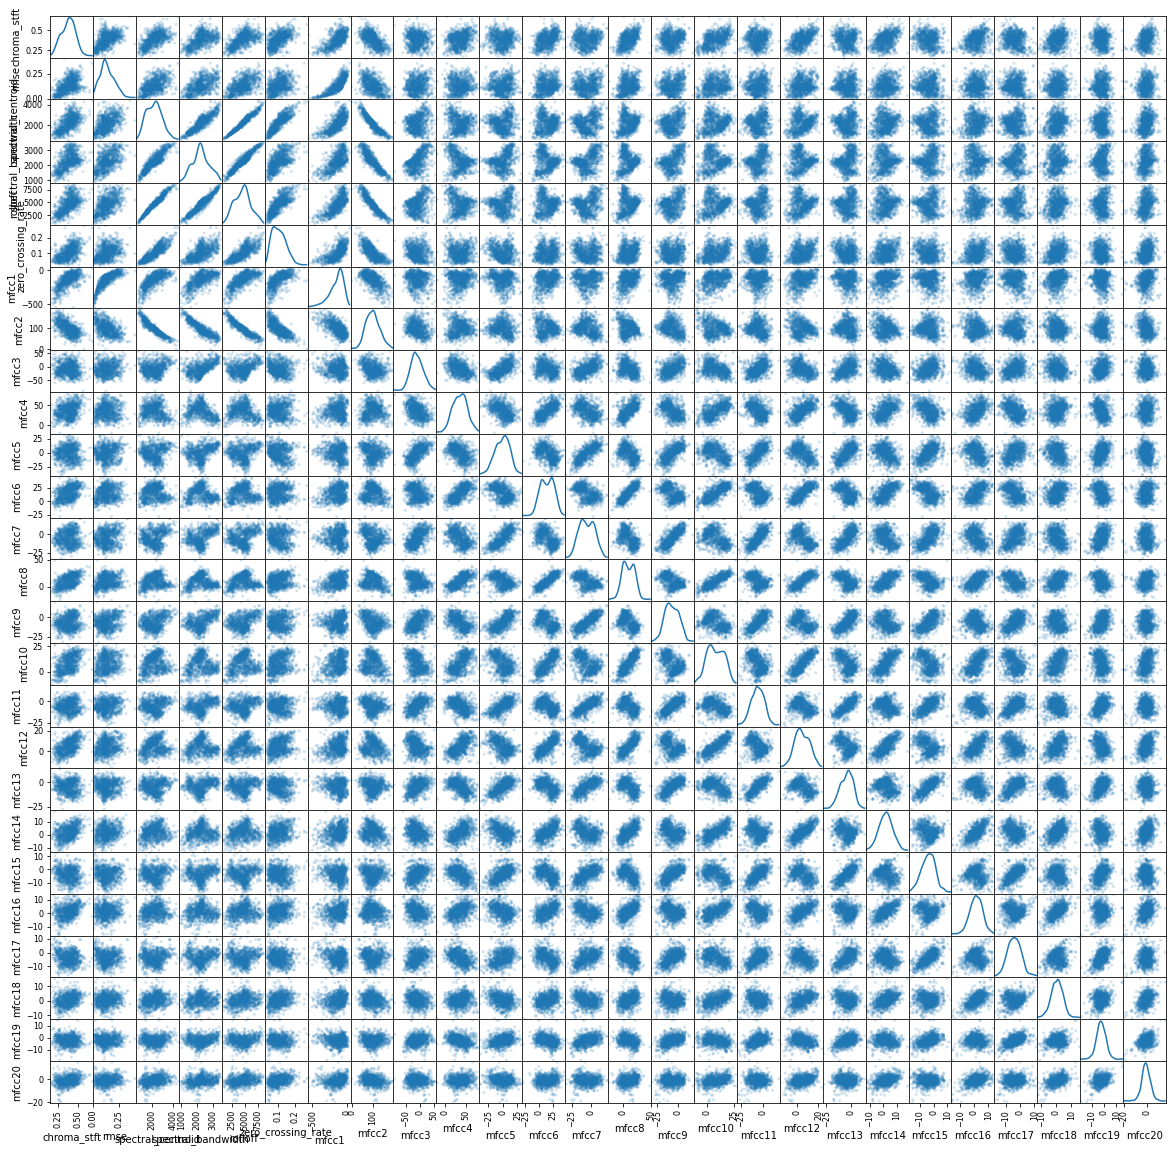

In [ ]:
nRowsRead = 1000
Spec_data=pd.read_csv("/content/drive/My Drive/music-genre-classification/Spec_data.csv",delimiter=',', nrows = nRowsRead)
Spec_data.describe()
nRow, nCol = Spec_data.shape
print(f'There are {nRow} rows and {nCol} columns')

scatter_matrix(Spec_data, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [ ]:
predicted_class_indices = np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions = predictions[:200]
filenames=test_set.filenames

In [ ]:
 print(len(test_set), len(predictions))

7 200


In [ ]:
results = pd.DataFrame({'Filename':filenames,'Predictions':predictions})
results.to_csv('prediction_results.csv',index = False)